# Decode

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json
from lib import dwt, huffman, ezw, size_amp, enc_dec, entropy
import cv2
import requests

In [6]:
img_path = '/home/fanqy/research-temp/eee5347/final-project/data/lena_reconstructed.png'
url = 'http://10.20.8.246:8000/lena_encoded.bin'

In [7]:
def imageDecoder_from_web(encoded_url, img_path):

    separator = '11110000101001011111000010100101'

    # Read the binary data from the file
    combined_data = enc_dec.read_from_url(encoded_url)

    # Split the combined data into the code table and the encoded data

    code_table_binary, quant_step_binary, recon_huffman_encoded_result_size, recon_encoded_data_lf, recon_huffman_encoded_rs_16_16, recon_ra_16_16_str = enc_dec.split_data(combined_data, separator)

    # Convert the binary code table back to a dictionary
    code_table = enc_dec.convert_binary_to_code_table(code_table_binary)

    # Convert the quantization step from binary to decimal
    quant_step = enc_dec.binary_str_to_float(quant_step_binary)

    # Decode the encoded data
    recon_result_size = enc_dec.decode_data_with_huffman(recon_huffman_encoded_result_size, code_table)
    recon_result_amplitude_str_lf = enc_dec.decode_data_plain(recon_encoded_data_lf)
    recon_rs_16_16 = enc_dec.decode_data_with_huffman(recon_huffman_encoded_rs_16_16, code_table)
    recon_ra_16_16_str = enc_dec.decode_data_plain(recon_ra_16_16_str)

    # recon dpr list
    recon_dpr_list = size_amp.size_amplitude_to_2D_list_optimized(recon_result_size, recon_result_amplitude_str_lf)

    # put the hf band back
    recon_img = np.zeros((512,512)).astype('float64')
    recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            # in order of quadrant 1,3,4
            child_1 = ezw.build_tree(recon_img, 1, (i,j+16), 1, None)
            child_3 = ezw.build_tree(recon_img, 1, (i+16,j), 3, None)
            child_4 = ezw.build_tree(recon_img, 1, (i+16,j+16), 4, None)
            recon_root_nodes[i][j] = ezw.EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
            child_1.parent = recon_root_nodes[i][j] # type: ignore
            child_3.parent = recon_root_nodes[i][j] # type: ignore
            child_4.parent = recon_root_nodes[i][j] # type: ignore
    
    recon_img = ezw.dec_dp_sp(recon_dpr_list, recon_root_nodes, recon_img)

    # decode top 16*16
    recon_top_16_16_diff = size_amp.size_amplitude_to_2D_list(recon_rs_16_16, recon_ra_16_16_str)[0][0]

    recon_top_16_16 = np.zeros(256).astype('int')
    recon_top_16_16[0] = recon_top_16_16_diff[0]
    for i in range(1, 256):
        recon_top_16_16[i] = recon_top_16_16[i-1] + recon_top_16_16_diff[i]
    # reshape to 16*16
    recon_top_16_16 = recon_top_16_16.reshape((16,16))

    # put top 16*16 back
    recon_img[0:16, 0:16] = recon_top_16_16

    # reverse quantization
    recon_img_after_quant = recon_img * quant_step

    # reconstruct the image
    l5_recon_img_after_quant = dwt.reconstruction_from_specify_level(recon_img_after_quant, 5)

    plt.imshow(l5_recon_img_after_quant, cmap='gray')
    plt.colorbar()

    # save the image use cv2, png
    cv2.imwrite(img_path, l5_recon_img_after_quant)

    # calculate psnr
    # mse = np.sum(np.square(img - l5_recon_img_after_quant)) / (512*512)
    # psnr = 10 * np.log10(255*255/mse)
    
    return l5_recon_img_after_quant

array([[167.70141602, 167.70141602, 166.38305664, ..., 159.79156494,
        143.70925903, 127.62695312],
       [167.70141602, 167.70141602, 166.38305664, ..., 159.79156494,
        143.70925903, 127.62695312],
       [166.49780273, 166.49780273, 165.40405273, ..., 161.63787842,
        146.3999939 , 131.16210938],
       ...,
       [ 44.96673584,  44.96673584,  53.47686768, ...,  93.51776123,
         94.32601929,  95.13427734],
       [ 40.12252808,  40.12252808,  52.69302368, ...,  96.77230835,
         98.85917664, 100.94604492],
       [ 35.27832031,  35.27832031,  51.90917969, ..., 100.02685547,
        103.39233398, 106.7578125 ]])

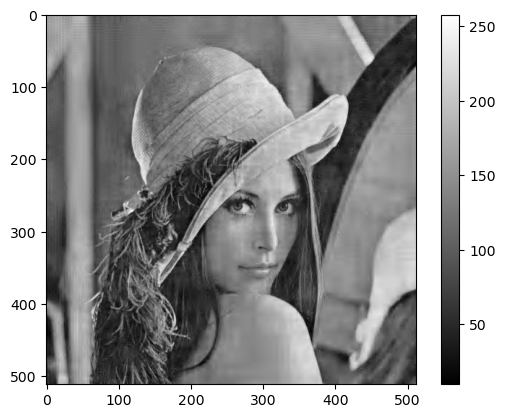

In [8]:
imageDecoder_from_web(url, img_path)